# Geophysical inversions with `SimPEG`
## An example with airborne electromagnetic data
Presenters:
Joseph Capriotti, Lindsey Heagy, Seogi Kang

In [1]:
import pandas as pd
import numpy as np
from utilities.gex_parser import parse_gex_file
import matplotlib.pyplot as plt

# Start with just importing the time domain module of simpeg, and a utility to plot a layered model.
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.utils import plot_1d_layer_model

import discretize

/var/folders/84/p2kwn61561lg6qxvs6gwhy780000gp/T/ipykernel_62329/3208045295.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Reading in the Data

First a bit about the skytem system. There are in general two sets of data:
* The low-moment data which is more sensitive to the near surface
* The high-moment data, which is (relatively) more sensitive to deeper structures.

The system has a hexagonal loop transmitter, with a $\frac{\partial \vec{B}}{\partial t}$ sensor.

There are two files that represent our data:
* A configuration file. Usually a `.gex` extension.
* The processed data file.
  * Simple CSV file $\rightarrow$ use `pandas`
 
We've provided a simple parser to read the information in the configuration file into python.

In [2]:
gex_file = parse_gex_file('../data/20170606_337m2_Cal_DualWaveform_60Hz_414_412_418.gex')

In [3]:
gex_file

{'General': {'Description': 'Test geometry file',
  'GPSDifferentialPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition2': array([10.51,  3.95, -0.16]),
  'AltimeterPosition1': array([12.94,  1.79, -0.12]),
  'AltimeterPosition2': array([12.94, -1.79, -0.12]),
  'InclinometerPosition1': array([12.79,  1.64, -0.12]),
  'InclinometerPosition2': array([12.79,  1.64, -0.12]),
  'RxCoilPosition1': array([-13.25,   0.  ,  -2.  ]),
  'LoopType': 72,
  'FrontGateDelay': 2.5e-06,
  'TxLoopArea': 337.04,
  'NumberOfTurnsLM': 1,
  'NumberOfTurnsHM': 4,
  'RxCoilLPFilter1': array([9.9e-01, 2.1e+05]),
  'TxLoopPoints': array([[-12.64,  -2.13],
         [ -6.15,  -8.59],
         [  5.74,  -8.59],
         [ 11.13,  -3.19],
         [ 11.13,   3.19],
         [  5.74,   8.59],
         [ -6.15,   8.59],
         [-12.64,   2.13]]),
  'Waveforms': {'HM': {'time': array([-3.22220e-02, -3.17433e-02, -3.11906e-02, -3.04936e-02,
           -2.96885e-02

Can simply use `pandas.read_csv` to read in the data file

In [4]:
data_file = pd.read_csv('../data/MCWD3_dat.xyz')
# you can alternatively use pandas to directly fetch this file from the internet
# data_file = pd.read_csv("https://github.com/simpeg/segns-2024-tutorial/raw/main/data/MCWD3_dat.xyz")
data_file

,LINE_NO,RECORD,UTMX,UTMY,TIMESTAMP,ELEVATION,ALT,INVALT,INVALTSTD,LM_DAT_00,...,HM_STD_18,HM_STD_19,HM_STD_20,HM_STD_21,HM_STD_22,HM_STD_23,HM_STD_24,HM_STD_25,HM_STD_26,HM_STD_27
0,100101,1,73305.896260,4.082421e+06,42873.747483,3.8,36.78,32.68,0.0224,1.657700e-08,...,0.0330,0.0353,0.0362,0.0367,0.0375,0.0381,0.0376,0.0394,0.0348,9999.0
1,100101,2,73337.025475,4.082420e+06,42873.747512,3.6,39.37,33.18,0.0193,1.598300e-08,...,0.0364,0.0360,0.0365,0.0371,0.0387,0.0388,0.0406,0.0410,0.0348,9999.0
2,100101,3,73361.647103,4.082401e+06,42873.747541,3.5,38.53,33.62,0.0202,1.477600e-08,...,0.0367,0.0365,0.0376,0.0379,0.0399,0.0406,0.0406,0.0410,0.0348,9999.0
3,100101,4,73378.387875,4.082370e+06,42873.747569,3.4,35.28,33.90,0.0243,1.472800e-08,...,0.0393,0.0379,0.0393,0.0391,0.0399,0.0406,0.0406,0.0410,0.0348,9999.0
4,100101,5,73395.783671,4.082335e+06,42873.747598,3.2,33.41,34.82,0.0248,1.278200e-08,...,0.0424,0.0401,0.0393,0.0391,0.0399,0.0406,0.0406,0.0410,0.0348,9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10605,212301,10606,83523.806947,4.076505e+06,42872.678588,35.7,38.96,41.34,0.0292,9.999000e+03,...,0.0386,0.0381,0.0373,0.0379,0.0388,0.0362,0.0380,9999.0000,9999.0000,9999.0
10606,212301,10607,83539.966456,4.076567e+06,42872.678617,35.9,41.35,44.34,0.0362,9.999000e+03,...,0.0372,0.0382,0.0358,0.0371,0.0368,0.0364,0.0380,9999.0000,9999.0000,9999.0
10607,212301,10608,83551.235351,4.076630e+06,42872.678646,35.8,44.19,47.13,0.0319,9.999000e+03,...,0.0360,0.0355,0.0350,0.0370,0.0366,0.0370,0.0380,9999.0000,9999.0000,9999.0
10608,212301,10609,83559.301122,4.076692e+06,42872.678675,35.2,47.19,50.22,0.0320,9.999000e+03,...,0.0347,0.0350,0.0344,0.0358,0.0372,0.0396,0.0402,9999.0000,9999.0000,9999.0


inside this data file, missing data are marked with the value 9999, let's replace them with NaNs instead (which the plotting utilities will then ignore).

In [5]:
data_file[data_file==9999] = np.NaN

Let's plot the location of all the stations in this survey

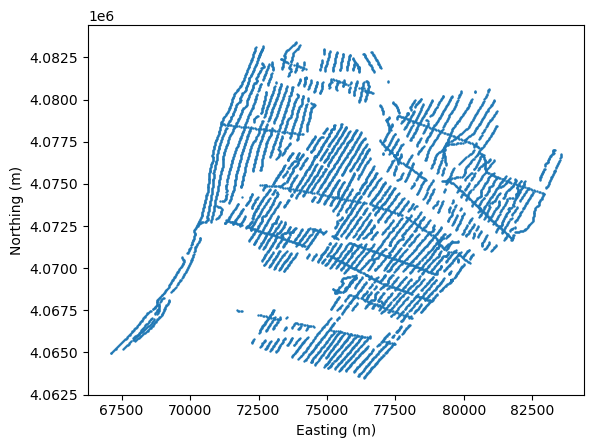

In [6]:
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.5)
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');

A few bits of processing have already been done to this data set, in particular, they have been normalized for source current strength, normalized by the transmitter area, and have also been spatially averaged along flight lines to form "stations".

Now we need a bit of information from the `.gex` file to tell us the number of high moment and low moment time gates for this survey

In [7]:
n_lm_gates = gex_file['Channel1']['NoGates'] - gex_file['Channel1']['RemoveInitialGates']
n_hm_gates = gex_file['Channel2']['NoGates'] - gex_file['Channel2']['RemoveInitialGates']

The data file will have `n_lm_gates` of db/dt data, `n_lm_gates` of relative error estimates, then `n_hm_gates` of the high moment db/dt data, followed by `n_hm_gates` relative error estimates.

### Zooming in to a single station to work with

Now let's look at a single station, along some randomly chosen line.

I can use panda's to easily group all of the data by a common line number
and then get that group

In [8]:
line_no = 206301
line_grouping = data_file.groupby('LINE_NO')
line = line_grouping.get_group(line_no)

Let's look at all the data along that line.

In [9]:
lm_data = line.iloc[:, 9:9+n_lm_gates]
hm_data = line.iloc[:, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates]

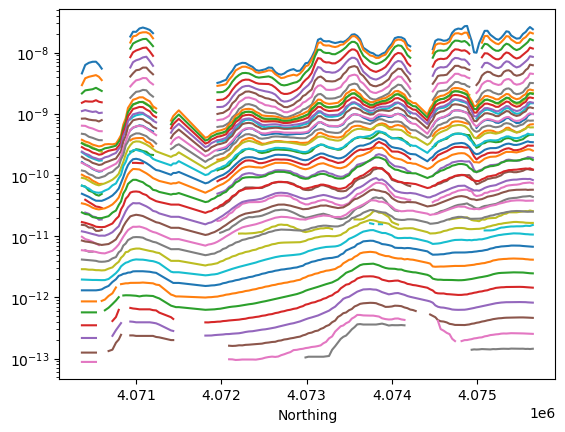

In [10]:
plt.semilogy(line.UTMY, lm_data)
plt.semilogy(line.UTMY, hm_data)
plt.xlabel('Northing');

In [11]:
# select a single sounding along that line, and grab all of the data associated with that station
# Record 5590
station = line[line.RECORD==5590]
station_lm_data = station.iloc[0, 9:9+n_lm_gates].to_numpy()
station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
station_hm_data = station.iloc[0, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates].to_numpy()
station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()

Now we have numpy arrays of the recorded data for both the low and high moment data sets, along with their relative standard deviations.

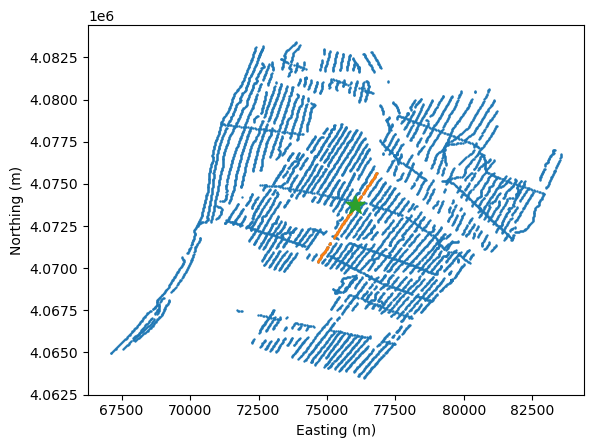

In [12]:
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.5)
plt.scatter(line.UTMX, line.UTMY, s=0.5)
plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');

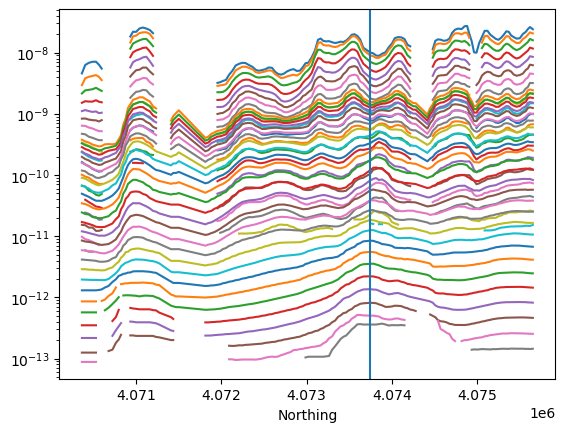

In [13]:
plt.semilogy(line.UTMY, lm_data)
plt.semilogy(line.UTMY, hm_data)
plt.axvline(station.UTMY.iloc[0]);
plt.xlabel('Northing');

In order to model the data, we still need a few things pieces of information.
* The location in time of the measurements
* The transmitter waveforms
* The transmitter shape
* The receiver location

In [14]:
# In general the location of the gates is
# gate_time = gate_centers + shift + delay
# The Gex file also tells us which gates the respective moments use
gate_centers = gex_file['General']['GateTimes']['center']

channel_info = gex_file['Channel1']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
lm_times = gate_centers[first_gate:last_gate] + shift + delay

channel_info = gex_file['Channel2']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
hm_times = gate_centers[first_gate:last_gate] + shift + delay

Some of the station's data are NaN's (which represent no data), Let's remove those points from our consideration

In [15]:
lm_good_data = ~np.isnan(station_lm_data)
hm_good_data = ~np.isnan(station_hm_data)

lm_times = lm_times[lm_good_data]
hm_times = hm_times[hm_good_data]

station_lm_data = station_lm_data[lm_good_data]
station_lm_std = station_lm_std[lm_good_data]
station_hm_data = station_hm_data[hm_good_data]
station_hm_std = station_hm_std[hm_good_data]

# and of course reset our counts too
n_lm_gates = len(lm_times)
n_hm_gates = len(hm_times)

and finally plot some decay curves.

This is the data we will try to match.

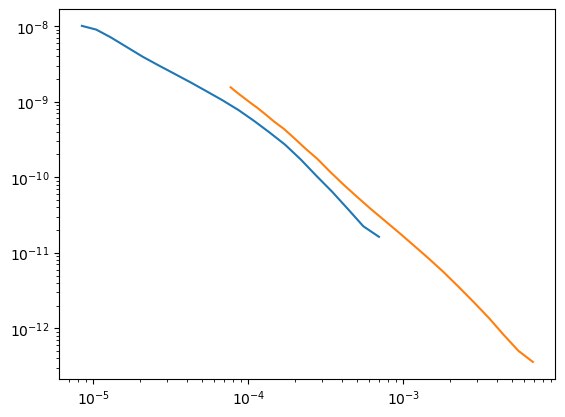

In [16]:
plt.loglog(lm_times, station_lm_data)
plt.loglog(hm_times, station_hm_data)

### Setting up the survey

Now we want represent all of the configuration with `SimPEG` objects.

SimPEG's general structure to hold this information is:
* Create `Receiver`s (that observe data)
* Create `Source`s (and attach receivers to those sources)
* Gather all the sources into a `Survey`

In the time-domain EM module:

* `Receivers`
    * Observe at a specific location in space.
    * Observe a specific component (Here it will be the vertical component of $\frac{d\vec{B}}{dt}$)
    * At specific times (the time-gate centers).
 
* `Sources`
    * Have specific types (Line Current, Magnetic Dipole, etc.)
    * Have a location (or set of locations for Line current)
    * Have waveforms
    * Are "listened to" by receivers.

So let's start by grabbing the information we will need from the gex file.

We already have the time gate locations. So, let's grab all of the information related to the transmitter.

Specifically here, the waveforms of the low and high moment sources.

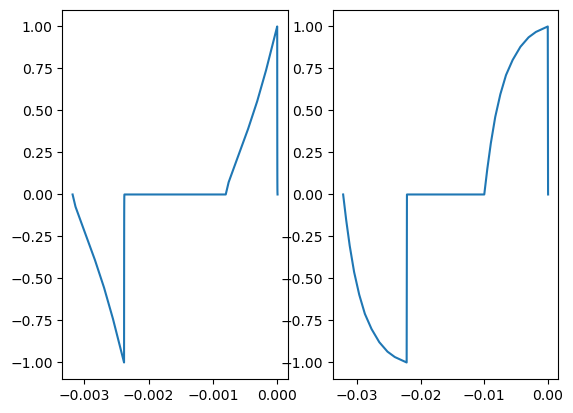

In [17]:
waves = gex_file['General']['Waveforms']
lm_wave_time = waves['LM']['time']
lm_wave_form = waves['LM']['form']
hm_wave_time = waves['HM']['time']
hm_wave_form = waves['HM']['form']
plt.subplot(121)
plt.plot(lm_wave_time, lm_wave_form)
plt.subplot(122)
plt.plot(hm_wave_time, hm_wave_form);

The shape of the transmitter , and the offset of the receiver coil.

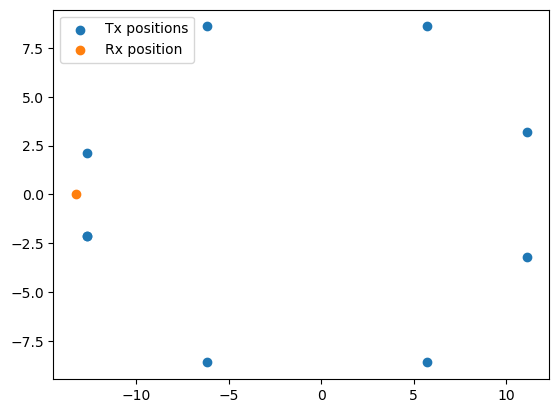

In [18]:
# We pad the locations of the Tx points with 0, to expand it from a 2D (x,y) pair to a 3D (x, y, z) pair.
# We also add another row because we will need to close the transmitter loop.
tx_shape = np.pad(gex_file['General']['TxLoopPoints'], (0, 1))
tx_shape[-1] = tx_shape[0]

rx_offset = gex_file['General']['RxCoilPosition1']

plt.scatter(*tx_shape[:, :-1].T, label='Tx positions')
plt.scatter(*rx_offset[:-1], label='Rx position')
plt.legend()

In [74]:
tx_shape

array([[-12.64,  -2.13,   0.  ],
       [ -6.15,  -8.59,   0.  ],
       [  5.74,  -8.59,   0.  ],
       [ 11.13,  -3.19,   0.  ],
       [ 11.13,   3.19,   0.  ],
       [  5.74,   8.59,   0.  ],
       [ -6.15,   8.59,   0.  ],
       [-12.64,   2.13,   0.  ],
       [-12.64,  -2.13,   0.  ]])

Let's give the transmitter and receiver explicit locations by adding the UTM coordinates of the station to the transmitter shape and the receiver offset.

In [19]:
tx_loc = tx_shape + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]
rx_loc = rx_offset + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]
# also let's grab the area
tx_area = gex_file['General']['TxLoopArea']

We are often asked how to deal with both the low and high moment data in SimPEG. The answer is actually fairly straightforward as long as you understand the structure of a SimPEG survey, we model them as two seperate sources (who just so happen to be in the same location).

In [20]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, lm_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(lm_wave_time, lm_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [21]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

Now we can set up a survey that has two sources!

In [22]:
srv = tdem.Survey([src_lm, src_hm])

Now we're ready to set up the forward simulation, of which we will use (for this tutorial), a Layered simulation.

It has two physical properties:
* The conductivity of each layer (`sigma`)
* The thickness of each layer (`thicknesses`)

In [23]:
#first a simple test
thicknesses = []
conductivities = [1E-2]

In [24]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

We can set these properties on the simulation and create data. The only requirement is that the conductivity array must be one longer than the thickness array.

**note**: For this simulation the conductivities and thicknesses are defined from the surface downwards.

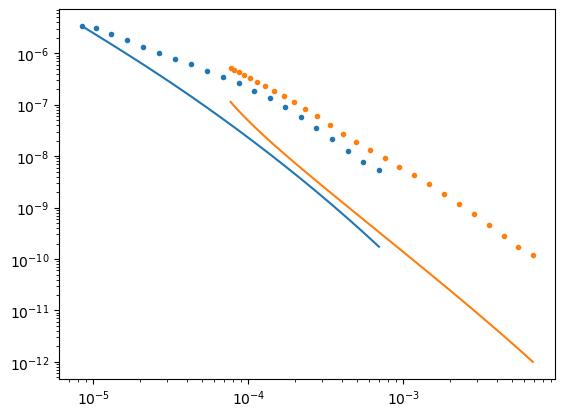

In [25]:
# sim.thicknesses = [5]
# sim.sigma = [3E-1]
pre = -sim.dpred(None)
pre_lm = pre[:n_lm_gates]
pre_hm = pre[n_lm_gates:]

plt.loglog(lm_times, pre_lm)
plt.loglog(hm_times, pre_hm)
plt.loglog(lm_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='')
plt.loglog(hm_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='')

# Setup an inversion

An inversion has many pieces that we must all setup for simpeg.

There are:
* `Map`: Objects that tell simpeg what to invert for.
* `Data`: a container for the observed data, its standard deviation, and the survey.
* `ObjectiveFunctions`, which describe the function we minimize to perform the inversion.
    * `DataMisfit`: How we measure the fitness of a model to the observed data.
    * `Regularization`: A measure of the simplicity of a model.
* `Minimization` Routines: Which method we use to iteratively minize the objective function.
* `InverseProblem`: Defines the optimization problem and the minimization routine.
* `Directives`: Operations that adjust parameters in the objective function as the inversion proceeds.
* `Inversion`: Groups together all of the above to actually run an inversion.

We will start by describing parametric inversions for simple 1D models, where the number of layers we invert for is much less than the number of data.

## Maps
This is how we tell simpeg what to invert for.

Maps define how we go from our inversion model to the physical properties.

In [26]:
from SimPEG import maps

for example, this is a simple map that will transform its input according to:
$$out = e^{in}$$

In [27]:
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

This map is particularly useful for solving for conductivity for two reasons:
1) Generally conductivity varies on a logarithmic scale
2) We do not need to handle positivity constraints while minimizing

We use maps in `SimPEG` to tell simulations what we will be inverting for.

## Data
We need to create a container for the data, things to remember about here:

* The processed data were normalized by the transmitter area.
* There is a sign difference in the convention for SimPEG and the processed data
* The standard deviations are actually relative errors.

In [28]:
from SimPEG import data

In [29]:
dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
rel_err = np.r_[station_lm_std, station_hm_std]

data_container = data.Data(srv, dobs=dobs, relative_error=rel_err)
data_container.nD

47

Since the data container knows about the survey, we can directly index it
with sources and receivers to retrieve the data associated with that pair.

This is particularly useful to ensure that you have passed your observed data in the order that `SimPEG` expects it.

In [30]:
data_container[src_hm, rx_hm]

array([-5.22984968e-07, -4.73709720e-07, -4.26490416e-07, -3.77484800e-07,
       -3.26898466e-07, -2.79099454e-07, -2.29200682e-07, -1.83201462e-07,
       -1.47401074e-07, -1.11199607e-07, -8.10783424e-08, -5.90797416e-08,
       -4.01515752e-08, -2.73898926e-08, -1.88300878e-08, -1.29598621e-08,
       -9.01211256e-09, -6.21602872e-09, -4.22007784e-09, -2.84000015e-09,
       -1.86898791e-09, -1.18900971e-09, -7.44015800e-10, -4.58913664e-10,
       -2.74300004e-10, -1.69399674e-10, -1.21098472e-10])

## Parametric Halfspace inversion.

With a few key component concepts out of the way, Let's see how we can setup the layered simulation to solve for the best fitting halfspace.

Let's setup a new simulation that does this, we can re-use our previous survey object.

In [31]:
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)

When we assign a model (or pass a model to a function), the simulation uses the physical property maps to translate the model to the physical properties

In [32]:
sim_inv1.model = np.log(np.r_[1E-5])
sim_inv1.sigma

array([1.e-05])

### Objective functions

SimPEG treats inversions as minimization functions, as such we need an objective function to minimize. For parametric inversions a data misfit is usually sufficient.

$$
\phi = \phi_d + \beta \phi_m
$$

We will start by defining just a simple data misfit function
* It needs to know how to compute data
* The data set you want to compare against.

It needs to be able to evaluate:
$$
\phi_d = |W_d ( d_{obs} - F(m))|^2
$$

In [33]:
from SimPEG.data_misfit import L2DataMisfit

In [34]:
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

We can evaluate the data misfit of a particular model by calling this object. (It also knows how to do derivative and (approximate) Hessian operations needed for minimization).

In [35]:
# we can evaluate this function.
m_0 = np.log(1E-2)  # sigma = 1E-2 S/m

phi_d_1(m_0)

10162.566345105486

If we wanted to know the best fitting halfspace for this data we could simply minimze this function. Let's grab a Gauss Newton minimizer.

In [36]:
from SimPEG import optimization

In [37]:
minimizer = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)
# Here, Inexact means we are going to use CG to solve for the step direction.

Define our inverse problem to be minimized:
One odd quirk of a SimPEG minimization is that we must pass a regularization object to our inverse problem. However we can set `beta=0` to ignore it.

In [38]:
from SimPEG import regularization, inverse_problem

empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
# note we needed to pass a mesh that had a single cell
# in it because our model has 1 value.

In [39]:
inv_prob_1 = inverse_problem.BaseInvProblem(
    phi_d_1, reg=empty_reg, opt=minimizer, beta=0.0
)

# sets up, phi_d + 0 * phi_m, meaning the minimizer is only going to act on the data misfit term.

In [40]:
from SimPEG import inversion

In [41]:
inv1 = inversion.BaseInversion(inv_prob_1, [])

In [42]:
# Run inversion
recovered_model = inv1.run(m_0)

SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.02e+04  0.00e+00  1.02e+04    3.00e+03      0              
   1  0.00e+00  1.23e+03  3.21e+00  1.23e+03    2.34e+03      0              
   2  0.00e+00  5.98e+02  4.33e+00  5.98e+02    5.49e+02      0   Skip BFGS  
   3  0.00e+00  5.76e+02  4.54e+00  5.76e+02    1.14e+02      0   Skip BFGS  
   4  0.00e+00  5.75e+02  4.58e+00  5.75e+02    2.33e+01      0   Skip BFGS  
   5  0.00e+00  5.75e+02  4.58e+00  5.75e+02  

In [43]:
# What was our recovered best fitting halfspace?
sim_inv1.sigmaMap * recovered_model

array([0.20663495])

There's another useful way of computing data from a simulation, using the function
`make_synthetic_data` which returns a `Data` object instead of just the `numpy` array.

In [44]:
# This function returns a data object
# (so we can easily index it with receivers for plotting)
data_pre = sim_inv1.make_synthetic_data(recovered_model)

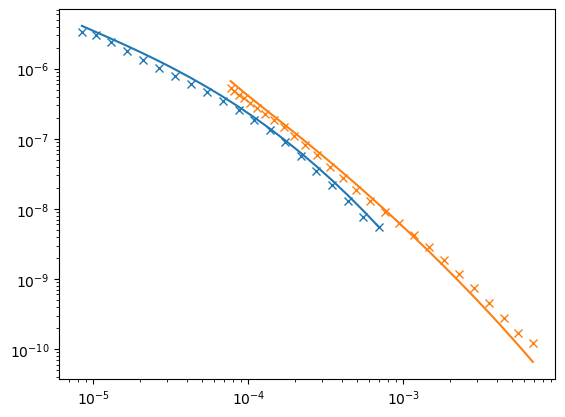

In [45]:
def plot_data(data_obj):
    plt.loglog(lm_times, -data_obj[src_lm, rx_lm])
    plt.loglog(hm_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        lm_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        hm_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )
plot_data(data_pre)

clearly a 1D model fits this reasonably well (in general), can we do better?

### Multiple layers?

How do we solve for a multi (but few) layered model? We need to tell simpeg to invert for both conductivity and thickness.

Since we also need to ensure thicknesses are positive, lets use another `ExpMap` for them, but now our `model` consists of both values representing conductivity and thicknesses, so we need to tell SimPEG which parts correspond to each of them. There is a simple helper class to construct these called a `Wires`. It is very simple it says the first `X` values correspond to part 1, the next `Y` correspong to part 2.

In [46]:
n_layers = 2
wire_map = maps.Wires(('sigma',n_layers), ('thicknesses', n_layers-1))

It contains to projection maps which split the model into its conductivities and thickness portions, we still need to use the `exp_map` to say we want to work in the log domain.

In [47]:
sigma_map = exp_map * wire_map.sigma
thick_map = exp_map * wire_map.thicknesses

In [48]:
# let's use the best fitting half-space as our initial model
m_sigma_0_2 = np.full(n_layers, recovered_model[0])  # Already in log-space
m_h_0_2 = np.log(np.full(n_layers-1, 10))
m_0_2 = np.r_[m_sigma_0_2, m_h_0_2]

sim_inv2 = tdem.Simulation1DLayered(srv, sigmaMap=sigma_map, thicknessesMap=thick_map)

In [49]:
sim_inv2.model = m_0_2
sim_inv2.sigma

array([0.20663495, 0.20663495])

Now we can set up the same pieces as the half-space inversion.

In [50]:
phi_d_2 = L2DataMisfit(data=data_container, simulation=sim_inv2)

# create all of the same components of the inversion problem as before
minimizer2 = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# again create a reg that has the same input size as the model vector, and then turn it off by setting `beta=0`
empty_reg = regularization.Smallness(discretize.TensorMesh([len(m_0_2)]))
inv_prob_2 = inverse_problem.BaseInvProblem(
    phi_d_2, reg=empty_reg, opt=minimizer, beta=0.0
)

And run it!

In [51]:
inv2 = inversion.BaseInversion(inv_prob_2, [])

# Run inversion
recovered_model_2 = inv2.run(m_0_2)

The callback on the InexactGaussNewton Optimization was replaced.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  5.75e+02  0.00e+00  5.75e+02    1.80e+03      0   Skip BFGS  
   1  0.00e+00  1.65e+02  3.00e-02  1.65e+02    2.95e+02      0   Skip BFGS  
   2  0.00e+00  1.24e+02  6.11e-02  1.24e+02    1.41e+02      0   Skip BFGS  
   3  0.00e+00  1.15e+02  9.68e-02  1.15e+02    3.08e+01      0   Skip BFGS  
   4  0.00e+00  1.15e+02  1.06e-01  1.15e+02    2.40e+00  

In [52]:
data_pre_2 = sim_inv2.make_synthetic_data(recovered_model_2)
sim_inv2.sigma, sim_inv2.thicknesses

(array([0.10980707, 0.26158568]), array([6.44465283]))

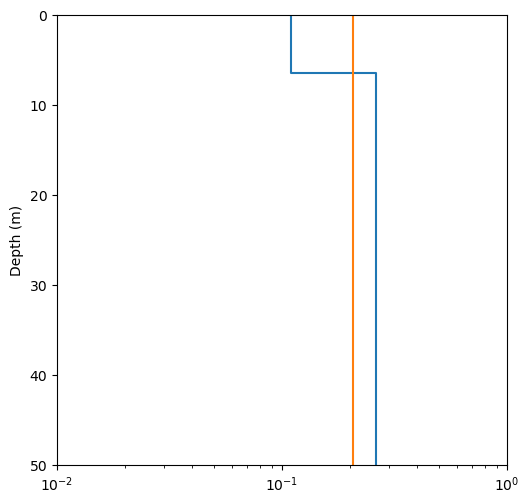

In [53]:
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
ax.set_ylim([50, 0])
ax.set_xlim([1E-2, 1E0]);

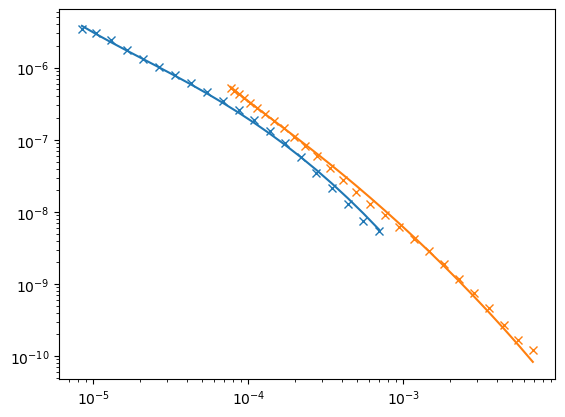

In [54]:
plot_data(data_pre_2)

We could keep going this route to add more and more layers, but at some point we start to enter the realm of underdetermined problems. E.g. when the number of model parameters exceed the number of observed data. For this we need to think about the regularization objective function.

## Regularized inversion

Let's keep building off of the pieces we had before. Let's discretize our model into many different layers. But this time we will only invert for the conductivity of each layer. For this we need to set up a mesh. This should be a 1D mesh, and it's single dimension would represent depth, aka we define z+ down for this example (Most simpeg is z+ up though).

We're going to define it with a single cell at 1m thickness, then increase the sizes geometrically by a factor of 1.05, for a total of 64 cells.

In [55]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 63, 1.05)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 64 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64          0.00        434.09      1.00     21.62    1.05

This time we only need to setup a simulation that inverts for conductivity, but we give it the thickness of each layer.
Which would be the `h[0]` property on the mesh, but truncated to 63 cells. (The last layer is interpreted as infinity depth.

In [56]:
sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])

Define yet another data misfit measure

In [57]:
phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)

Now we need to also create a meaningful regularization function.

We're going to use something like:
$$
\phi_m = \alpha_v \int_V m^2 dV + \alpha_z \int_V (\frac{\partial m}{\partial z})^2 dV 
$$

In [58]:
# This class creates a function that measures the smallness
# and the smoothness of the model.
reg = regularization.WeightedLeastSquares(mesh)

This class has some good default choices for $\alpha_s$ and $\alpha_x$

$$\alpha_s=1$$
$$\alpha_z = min(mesh.h)^2$$

In [59]:
m_0_reg = np.full(mesh.n_cells, recovered_model[0])

In [60]:

# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

inv_prob_3 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=5
)

In [61]:
inv3 = inversion.BaseInversion(inv_prob_3, [])

# Run inversion
recovered_model_3 = inv3.run(m_0_reg)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  5.75e+02  4.61e-32  5.75e+02    5.97e+02      0              
   1  5.00e+00  8.00e+01  8.44e+00  1.22e+02    1.60e+02      0              
   2  5.00e+00  4.28e+01  8.31e+00  8.44e+01    2.14e+01      0   Skip BFGS  
   3  5.00e+00  4.13e+01  8.43e+00  8.34e+01    2.00e+00      0   Skip B

(0.01, 1.0)

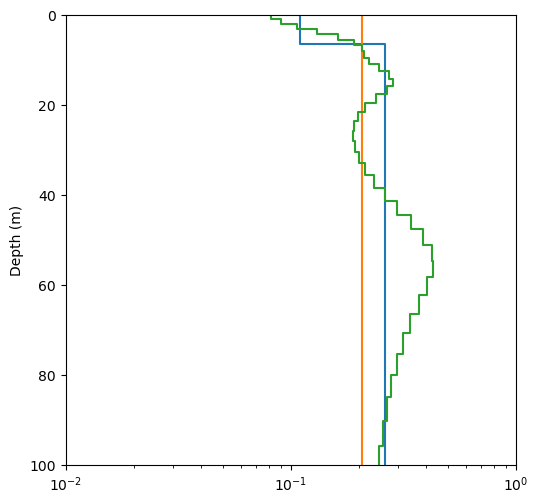

In [62]:
data_pre_3 = sim_reg.make_synthetic_data(recovered_model_3)
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
plot_1d_layer_model(sim_reg.thicknesses, sim_reg.sigma, ax=ax, color='C2')
ax.set_ylim([100, 0])
ax.set_xlim([1E-2, 1E0])

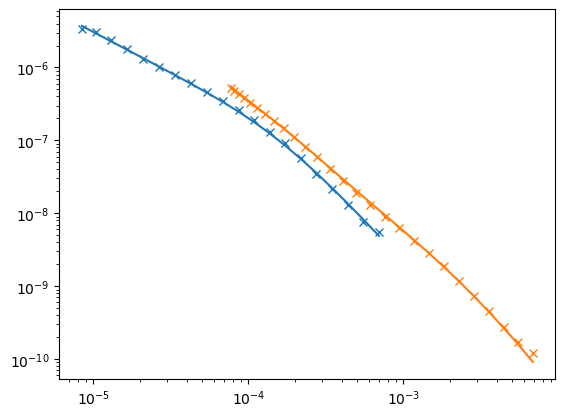

In [63]:
plot_data(data_pre_3)

If we knew our noise level, We usually look for a model such that tit's $\phi_d(m) <= nD/2$. This comes from the expected value of a chi^2 disrtibutionl.

This process of manually adjusting the regularization parameter is a bit tiresome. In SimPEG we can use `Directive`s to automate this process for us.

Say we want to decrease the regularization parameter by a factor of 5 every two iterations:

In [64]:
from SimPEG import directives

In [65]:
beta_cooler = directives.BetaSchedule(coolingFactor=5, coolingRate=2)

we also would likely want to keep track of the model and the function values at each iteration

In [66]:
save_dict = directives.SaveOutputDictEveryIteration()

We combine these into a list, and pass them to the inversion.

In [67]:
# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

inv_prob_4 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000
)

inv4 = inversion.BaseInversion(inv_prob_4, [save_dict, beta_cooler])

# Run inversion
recovered_model_4 = inv4.run(m_0_reg)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+04  5.75e+02  4.61e-32  5.75e+02    5.97e+02      0              
   1  1.00e+04  5.47e+02  1.33e-03  5.61e+02    7.87e+00      0              
   2  2.00e+03  5.48e+02  1.31e-03  5.50e+02    4.56e+02      0              
   3  2.00e+03  4.68e+02  2.43e-02  5.17e+02    2.21e+01      0              
   4  4.00e+02  4.70e+02  2.34e-02  4.79e+02    3.91e+02      0              
   5  4.00e+02  3.12e+02  2.30e-01  4.04e+02    3.89e+01      0              
   6  8.00e+01  3.16e+02  2.19e-0

The returned model here is just the last model from the inversion run, it might not necessarily be the best one though...

The `save_dict.outDict` dictionary is indexed per iteration, returning another dictionary containing the parameters and function evaluations. Let's collect all of the $\phi_d$, $\phi_m$ and $\beta$

In [68]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

We can make a few plots to investigate how these function evaluations change per iteration

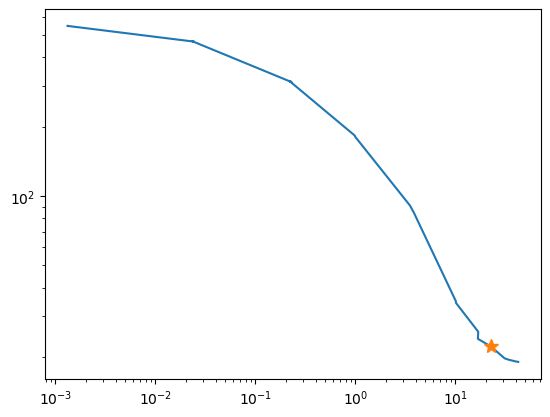

In [69]:
# this is an L-curvey plot
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[14], phi_ds[14], marker='*', markersize=10)

And what does the model and data look like at this point?

(0.01, 1.0)

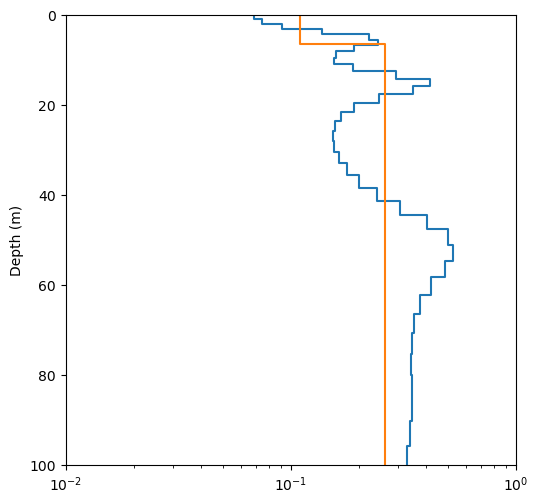

In [70]:
m_final = save_dict.outDict[14]['m']
d_final = sim_reg.make_synthetic_data(m_final)
ax = plot_1d_layer_model(sim_reg.thicknesses, exp_map * m_final)
plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma, ax=ax)
ax.set_ylim([100, 0])
ax.set_xlim([1E-2, 1E0])

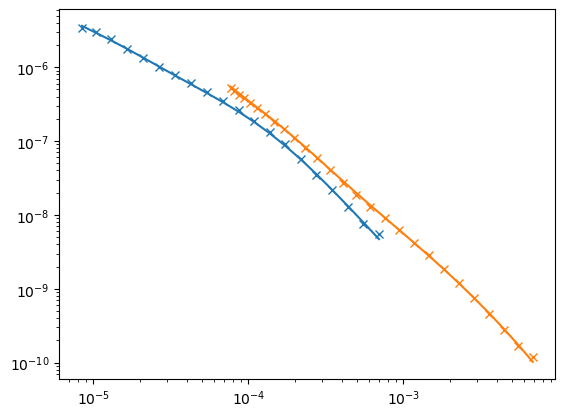

In [71]:
plot_data(d_final)

**note** The overall fit looks fairly close.

You might ask..
"What is the noise level corresponding to this regularization parameter?"
There's a few ways you can define it, let's compare the relative sizes of the data residual vector to the observed data vector.

In [73]:
rel_diff = np.abs((data_container.dobs - d_final.dclean)/data_container.dobs)
rel_diff.mean()

0.031092072787911425

So a 3.1% difference on average (that's not too far off from the 3% assumed relative error in the SkyTEM surveys!)